In [23]:
library(tidyverse)
library(GGally)  # ggpairs
library(MuMIn)  # AICc (Akaike Information Criterion corrected for small sample size)
library(MASS)  # negative.binomial
library(readr)
library(ggplot2)
library(gridExtra)
library(rstanarm)
library(pROC)
library(boot)
library(foreign)
library(arm)
library(lattice)
library(lme4)
library(dplyr)
library(parallel)
library(caret)
library(klaR)
library(e1071)
library(randomForest)
library(glmnet)
library(broom)

source("functions.r")
data <- read_csv("cardio_train_clean.csv", col_types = cols())

In [24]:
head(data)

id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,1,168,62,110,80,1,1,0,0,1,0,21.96712
1,0,0,156,85,140,90,3,1,0,0,1,1,34.92768
2,0,0,165,64,130,70,3,1,0,0,0,1,23.50781
3,0,1,169,82,150,100,1,1,0,0,1,1,28.71048
4,0,0,156,56,100,60,1,1,0,0,0,0,23.01118
8,0,0,151,67,120,80,2,2,0,0,0,0,29.38468


In [25]:
data$smoke <- factor(data$smoke)
data$alco <- factor(data$alco)
data$active <- factor(data$active)
data$cardio <- factor(data$cardio)

In [26]:
# Dividindo os dados em conjuntos de treinamento (70%) e teste (30%)
sample <- sample(c(TRUE, FALSE), nrow(data), replace=TRUE, prob=c(0.7,0.3))
train <- data[sample, ]
test <- data[!sample, ]

In [55]:
model1 <- glm(cardio ~ age + weight + gender + height + IMC + ap_hi + ap_lo + cholesterol + gluc + smoke + alco + active,
             data = train, family = binomial)

y_hat1 <- predict(model1, newdata = test, type = "response")

# Set a threshold to classify observations as 0 or 1
predicted_classes <- ifelse(y_hat1  > 0.5, 1, 0)

get_evaluation_metrics(predicted_classes, test$cardio)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


Accuracy: 0.7192795 
Precision: 0.6454253 
Recall: 0.7555606 
F1 Score: 0.696164 


In [28]:
summary(model1)


Call:
glm(formula = cardio ~ age + weight + height + IMC + ap_hi + 
    ap_lo + cholesterol + gluc + smoke + alco + active, family = binomial, 
    data = train)

Coefficients: (1 not defined because of singularities)
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.187231   1.208847  -7.600 2.96e-14 ***
age                NA         NA      NA       NA    
weight       0.005875   0.007975   0.737    0.461    
height      -0.003133   0.007356  -0.426    0.670    
IMC          0.016850   0.021224   0.794    0.427    
ap_hi        0.058422   0.001099  53.153  < 2e-16 ***
ap_lo        0.012303   0.001727   7.123 1.06e-12 ***
cholesterol  0.551781   0.018500  29.825  < 2e-16 ***
gluc        -0.095110   0.020951  -4.540 5.63e-06 ***
smoke1      -0.188852   0.039727  -4.754 2.00e-06 ***
alco1       -0.210495   0.050240  -4.190 2.79e-05 ***
active1     -0.207201   0.025890  -8.003 1.21e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion

In [56]:
model_ic(model1)

[1] 54725.56 54830.89 54725.56

In [57]:
coefficients1 <- coef(model1)

# Convert to odds ratios
odds_ratios1 <- exp(coefficients1)

# Print the odds ratios
print(odds_ratios1)

 (Intercept)          age       weight       gender       height          IMC 
0.0001124234           NA 1.0055539248 1.0329447817 0.9962756880 1.0179538372 
       ap_hi        ap_lo  cholesterol         gluc       smoke1        alco1 
1.0601147675 1.0123568328 1.7372350411 0.9093902358 0.8175683701 0.8077217851 
     active1 
0.8127675883 


In [58]:
summary <- tidy(model1)
summary

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-9.093238697,1.211458820,-7.5060238,6.095036e-14
age,NA,NA,NA,NA
weight,0.005538559,0.007981413,0.6939321,4.877248e-01
gender,0.032413734,0.026263791,1.2341605,2.171431e-01
height,-0.003731265,0.007373831,-0.5060144,6.128466e-01
IMC,0.017794571,0.021243339,0.8376541,4.022250e-01
ap_hi,0.058377173,0.001099692,53.0850033,0.000000e+00
ap_lo,0.012281110,0.001727426,7.1094839,1.164777e-12
cholesterol,0.552294793,0.018505582,29.8447668,1.026464e-195


In [59]:
mean_coef <- mean(summary$estimate)
confint(model1)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-11.468978038,-6.71971018
age,NA,NA
weight,-0.010104337,0.02118592
gender,-0.019070481,0.08388417
height,-0.018185972,0.01072158
IMC,-0.023831590,0.05945140
ap_hi,0.056229646,0.06054054
ap_lo,0.008895148,0.01566684
cholesterol,0.516107545,0.58865149
gluc,-0.136072717,-0.05394130


In [49]:
model2 <- glm(cardio ~ age + ap_hi + ap_lo + weight + cholesterol + gluc + smoke + alco + active,
             data = train, family = binomial)

y_hat2 <- predict(model2, newdata = test, type = "response")

# Set a threshold to classify observations as 0 or 1
predicted_classes2 <- ifelse(y_hat2 > 0.5, 1, 0)

get_evaluation_metrics(predicted_classes2, test$cardio)

Accuracy: 0.7187454 
Precision: 0.6448407 
Recall: 0.7549624 
F1 Score: 0.6955699 


In [32]:
model_ic(model2)

[1] 54760.01 54839.01 54760.01

In [33]:
coefficients2 <- coef(model2)

# Convert to odds ratios
odds_ratios2 <- exp(coefficients2)

# Print the odds ratios
print(odds_ratios2)

 (Intercept)          age        ap_hi        ap_lo       weight  cholesterol 
6.599609e-05           NA 1.060512e+00 1.012242e+00 1.010564e+00 1.751520e+00 
        gluc       smoke1        alco1      active1 
9.101778e-01 7.958751e-01 8.042163e-01 8.145469e-01 


In [34]:
summary <- tidy(model2)
summary

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-9.62591501,0.1228287339,-78.368593,0.000000e+00
age,NA,NA,NA,NA
ap_hi,0.05875158,0.0010985007,53.483420,0.000000e+00
ap_lo,0.01216725,0.0017269411,7.045548,1.847327e-12
weight,0.01050891,0.0007915311,13.276686,3.160746e-40
cholesterol,0.56048398,0.0184399901,30.395026,6.390525e-203
gluc,-0.09411535,0.0209414610,-4.494211,6.982827e-06
smoke1,-0.22831303,0.0392496119,-5.816950,5.993107e-09
alco1,-0.21788697,0.0502455157,-4.336446,1.448050e-05


In [35]:
mean_coef <- mean(summary$estimate)
confint(model2)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-9.867530546,-9.38603498
age,NA,NA
ap_hi,0.056606395,0.06091262
ap_lo,0.008782247,0.01555203
weight,0.008958795,0.01206164
cholesterol,0.524426285,0.59671310
gluc,-0.135187833,-0.05309427
smoke1,-0.305315585,-0.15145073
alco1,-0.316456008,-0.11948071
active1,-0.255845265,-0.15440895


In [60]:
model3 <- glm(cardio ~ age + weight + gender + ap_hi + ap_lo + cholesterol + gluc + smoke + alco + active,
             data = train, family = binomial)

y_hat3 <- predict(model3, newdata = test, type = "response")

# Set a threshold to classify observations as 0 or 1
predicted_classes3 <- ifelse(y_hat3  > 0.5, 1, 0)

get_evaluation_metrics(predicted_classes, test$cardio)

Accuracy: 0.7192795 
Precision: 0.6454253 
Recall: 0.7555606 
F1 Score: 0.696164 


In [61]:
coefficients3 <- coef(model3)

# Convert to odds ratios
odds_ratios3 <- exp(coefficients3)

# Print the odds ratios
print(odds_ratios3)

 (Intercept)          age       weight       gender        ap_hi        ap_lo 
6.569469e-05           NA 1.010766e+00 9.592586e-01 1.060526e+00 1.012288e+00 
 cholesterol         gluc       smoke1        alco1      active1 
1.748292e+00 9.099134e-01 8.130558e-01 8.081532e-01 8.144292e-01 


In [62]:
summary <- tidy(model3)
summary

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-9.63049241,0.1228528112,-78.390493,0.000000e+00
age,NA,NA,NA,NA
weight,0.01070806,0.0007995136,13.393213,6.625124e-41
gender,-0.04159462,0.0232911386,-1.785856,7.412259e-02
ap_hi,0.05876483,0.0010985250,53.494307,0.000000e+00
ap_lo,0.01221309,0.0017271280,7.071329,1.534563e-12
cholesterol,0.55863950,0.0184685939,30.248080,5.529679e-201
gluc,-0.09440590,0.0209430992,-4.507733,6.552390e-06
smoke1,-0.20695550,0.0410335674,-5.043566,4.569355e-07


In [63]:
mean_coef <- mean(summary$estimate)
confint(model3)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-9.872154534,-9.390564575
age,NA,NA
weight,0.009142334,0.012276476
gender,-0.087256906,0.004044688
ap_hi,0.056619603,0.060925920
ap_lo,0.008827728,0.015598246
cholesterol,0.522525363,0.594924307
gluc,-0.135481670,-0.053381687
smoke1,-0.287445753,-0.126588530
alco1,-0.311717422,-0.114452299


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = test$cardio ~ y_hat1, plot = TRUE, print.auc = TRUE)

Data: y_hat1 in 10334 controls (test$cardio 0) < 10263 cases (test$cardio 1).
Area under the curve: 0.7735

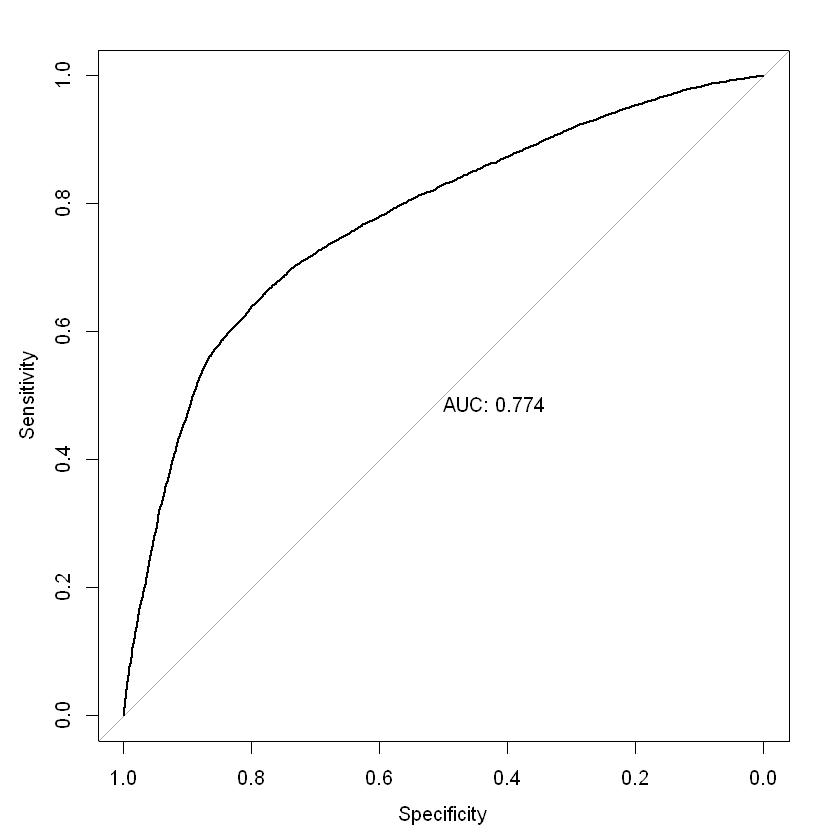

In [37]:
# Plot the ROC curve
roc(test$cardio ~ y_hat1, plot=TRUE, print.auc=TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = test$cardio ~ y_hat2, plot = TRUE, print.auc = TRUE)

Data: y_hat2 in 10334 controls (test$cardio 0) < 10263 cases (test$cardio 1).
Area under the curve: 0.7732

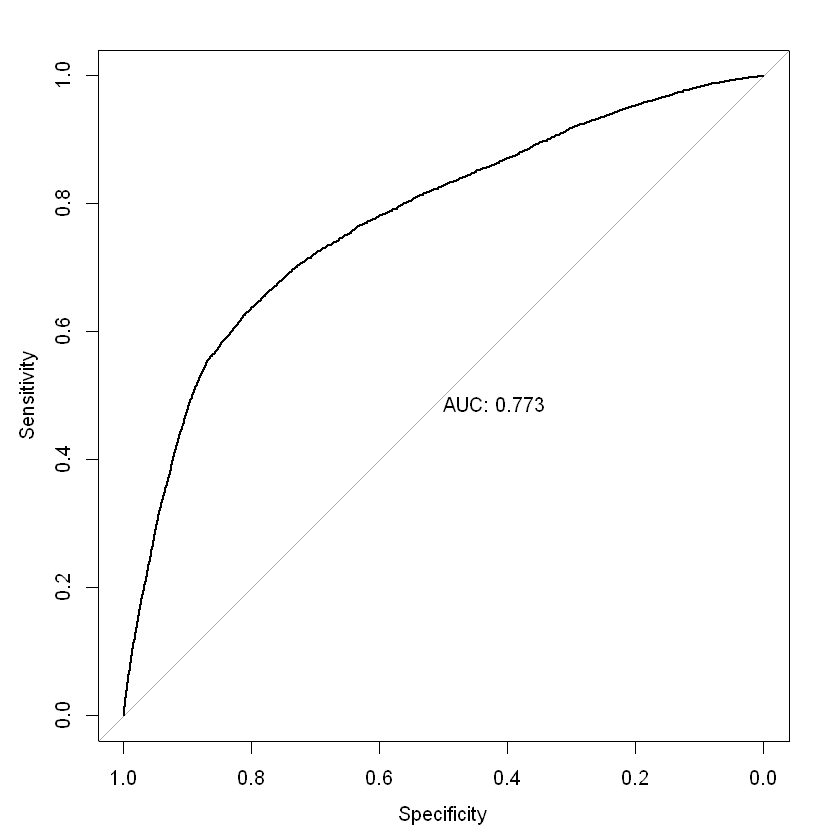

In [38]:
roc(test$cardio ~ y_hat2, plot=TRUE, print.auc=TRUE)

In [68]:
X <- data[, !(names(data) %in% c("cardio"))]
y <- data$cardio

data_split <- createDataPartition(y , p = 0.7, list = FALSE, times = 1)

# Extract the training and validation sets
X_train <- X[data_split, ]
X_val <- X[-data_split, ]
y_train <- y[data_split]
y_val <- y[-data_split]

# Define a list to store the accuracy values
model_dict <- list()

In [69]:
X <- model.matrix(cardio ~ age + weight + ap_hi + ap_lo + cholesterol + gluc + smoke + alco, data = train)[, -1]  # model.matrix gets the design matrix of the model
y <- train$cardio

# Define the cross-validation scheme
cvfit <- cv.glmnet(X, y, family = "binomial", type.measure = "class", alpha = 1,lambda = 10^seq(10, -2, length = 100))  # alpha = 1 for lasso penalty

# Find the best lambda value
best_lambda <- cvfit$lambda.min

# Train the final model with the best lambda
final_model <- glmnet(X, y, family = "binomial", alpha = 1, lambda = best_lambda, thresh = 0.0001)

[1] "Accuracy: 0.718793999126086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = test$cardio ~ y_hat, plot = TRUE, print.auc = TRUE)

Data: y_hat in 10334 controls (test$cardio 0) < 10263 cases (test$cardio 1).
Area under the curve: 0.7704

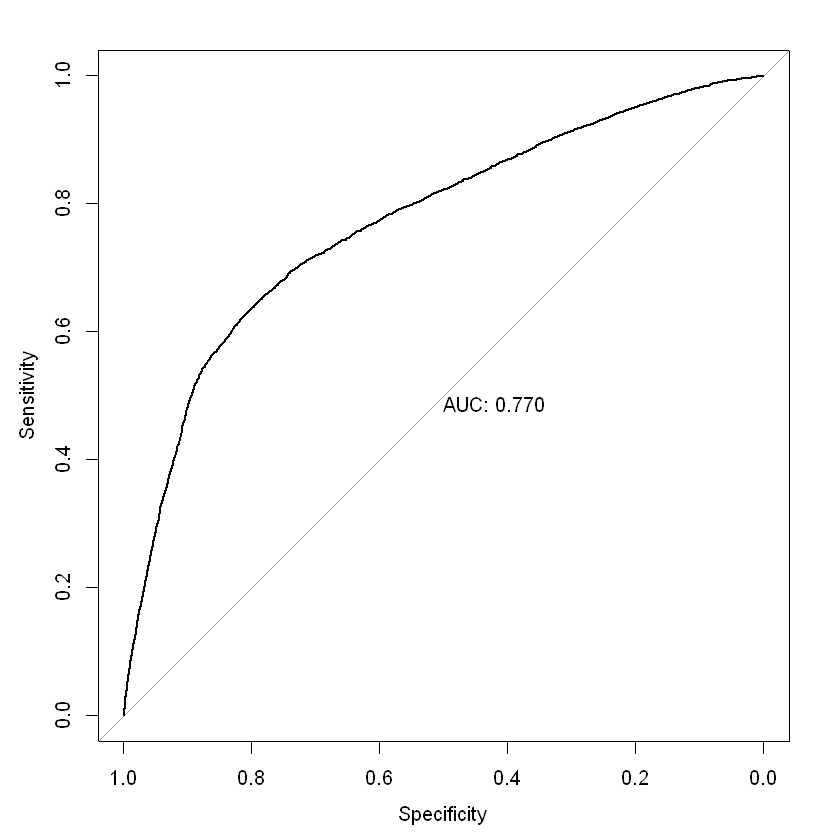

In [70]:
test_x <- model.matrix(cardio ~ age + weight + ap_hi + ap_lo + cholesterol + gluc + smoke + alco, data = test)[, -1]
y_hat <- predict(final_model, newx = test_x, type = "response", s = best_lambda)[, 1]

# Convert probabilities to class predictions
pred_class <- ifelse(y_hat > 0.5, 1, 0)

# Calculate accuracy
accuracy <- sum(pred_class == test$cardio) / length(test$cardio)
print(paste("Accuracy:", accuracy))

# Calculate AUC
roc(test$cardio ~ y_hat, plot=TRUE, print.auc=TRUE)

In [71]:
#Seleciona as linhas cuja idade está entre 50 e 60 anos
data2 <- test[test$age >= 50 & test$age <= 60, ]
data3 <- train[train$age >= 50 & train$age <= 60, ]

data2$smoke <- factor(data2$smoke)
data2$alco <- factor(data2$alco)
data2$active <- factor(data2$active)
data2$cardio <- factor(data2$cardio)

probs <- predict(model1, newdata = data2, type = "response")
mean_prob <- mean(probs)
print(mean_prob)

ERROR: Error in family(object)$linkinv(pred): Argumento eta deve ser um vetor numérico não-vazio


In [ ]:
probs <- predict(model2, newdata = data2, type = "response")
mean_prob <- mean(probs)
print(mean_prob)

[1] 0.5325504


In [ ]:
# Vamos verificar a proporção dessas pessoas que têm uma doença cardiovascular
prop_cardio <- mean(data3$cardio == 1)

print(prop_cardio)

[1] 0.5190397


In [67]:
#Seleciona as linhas cuja idade está entre 50 e 60 anos
data4 <- test[test$age >= 60 & test$age <= 65, ]
data5 <- train[train$age >= 60 & train$age <= 65, ]

data4$smoke <- factor(data4$smoke)
data4$alco <- factor(data4$alco)
data4$active <- factor(data4$active)
data4$cardio <- factor(data4$cardio)

probs <- predict(model1, newdata = data4, type = "response")
mean_prob <- mean(probs)
print(mean_prob)

ERROR: Error in family(object)$linkinv(pred): Argumento eta deve ser um vetor numérico não-vazio


In [ ]:
#Seleciona as linhas cuja idade está entre 50 e 60 anos
data4 <- test[test$age >= 60 & test$age <= 65, ]
data5 <- train[train$age >= 60 & train$age <= 65, ]

data4$smoke <- factor(data4$smoke)
data4$alco <- factor(data4$alco)
data4$active <- factor(data4$active)
data4$cardio <- factor(data4$cardio)

probs <- predict(model2, newdata = data4, type = "response")
mean_prob <- mean(probs)
print(mean_prob)

[1] 0.652683


In [ ]:
# Vamos verificar a proporção dessas pessoas que têm uma doença cardiovascular
prop_cardio <- mean(data5$cardio == 1)

print(prop_cardio)

[1] 0.6715084
